<a href="https://colab.research.google.com/github/Sonica-B/Deep-Learning-CS541_F2024/blob/HomeWork4/homework4(b)_Shreya_Boyane_Ankit_Gole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 28 * 28  # 784 for Fashion MNIST images
hidden_size1, hidden_size2 = 256, 128
num_classes = 10
learning_rate = 0.005
num_epochs = 10
batch_size = 64

# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Data loading with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load a subset of Fashion MNIST (1000 samples for simplicity)
train_dataset = FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_subset = Subset(train_dataset, range(1000))
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
# Training function to collect parameter vectors and losses
def train_and_collect_trajectory(model, data_loader, criterion, optimizer):
    model.train()
    trajectory, losses = [], []

    for epoch in range(num_epochs):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Record parameters and loss
            params = torch.cat([param.view(-1) for param in model.parameters()]).detach().cpu().numpy()
            trajectory.append(params)
            losses.append(loss.item())

    return np.array(trajectory), np.array(losses)

In [6]:
# Initialize two models with different random seeds
torch.manual_seed(0)
model1 = FCNN().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

torch.manual_seed(1)
model2 = FCNN().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate)

# Collect trajectories and losses for both models
trajectory1, losses1 = train_and_collect_trajectory(model1, train_loader, criterion, optimizer1)
trajectory2, losses2 = train_and_collect_trajectory(model2, train_loader, criterion, optimizer2)

# Combine trajectories for PCA
all_trajectories = np.concatenate([trajectory1, trajectory2])

# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca.fit(all_trajectories)

# Project trajectories onto the 2D PCA space
trajectory1_pca = pca.transform(trajectory1)
trajectory2_pca = pca.transform(trajectory2)

# Generate a grid for the loss landscape in PCA space
grid_x, grid_y = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-4, 5, 50))
grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]
grid_points_original = pca.inverse_transform(grid_points)

In [7]:
# Helper function to load parameters into the model
def load_params_into_model(model, params):
    start = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = torch.tensor(params[start:start + param_size]).view(param.size()).to(device)
        start += param_size

# Calculate loss values for each grid point
grid_losses = []
for params in grid_points_original:
    load_params_into_model(model1, params)
    total_loss = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Convert model1 weights to float32 before forward pass
            for param in model1.parameters():
                param.data = param.data.type(torch.float32)

            outputs = model1(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    grid_losses.append(total_loss / len(train_loader))

# Reshape losses to match the grid shape
grid_losses = np.array(grid_losses).reshape(grid_x.shape)

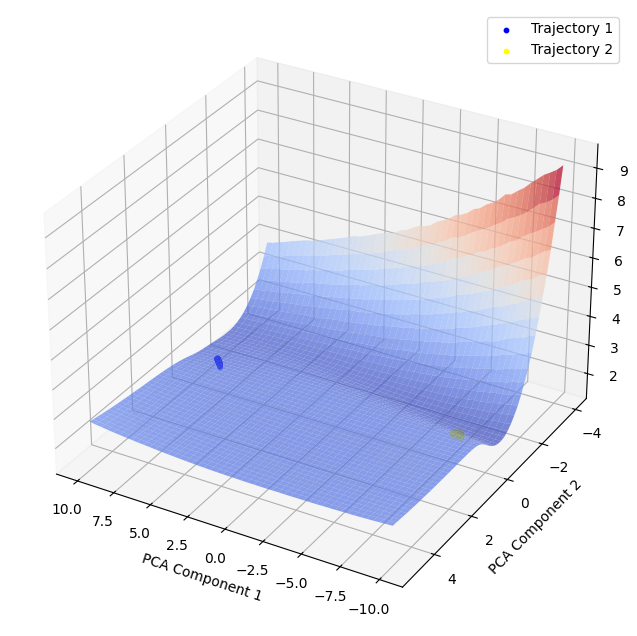

In [8]:
# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_losses, cmap='coolwarm', alpha=0.7)

# Plot the SGD trajectories
ax.scatter(trajectory1_pca[:, 0], trajectory1_pca[:, 1], losses1, c='blue', s=10, label='Trajectory 1')
ax.scatter(trajectory2_pca[:, 0], trajectory2_pca[:, 1], losses2, c='yellow', s=10, label='Trajectory 2')

# Set labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('Train Loss')
ax.view_init(elev=30, azim=120)  # Adjust view angle if needed
plt.legend()
plt.show()